
--- Rodando Simulação 2D com Adam-HD ---

Plotando a trajetória na paisagem de perda 2D:


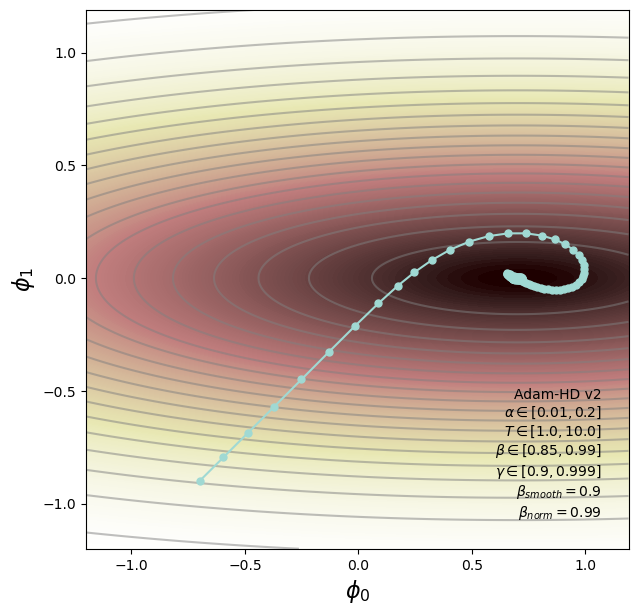


--- Plotando estados internos do otimizador para: 2D Simulation ---


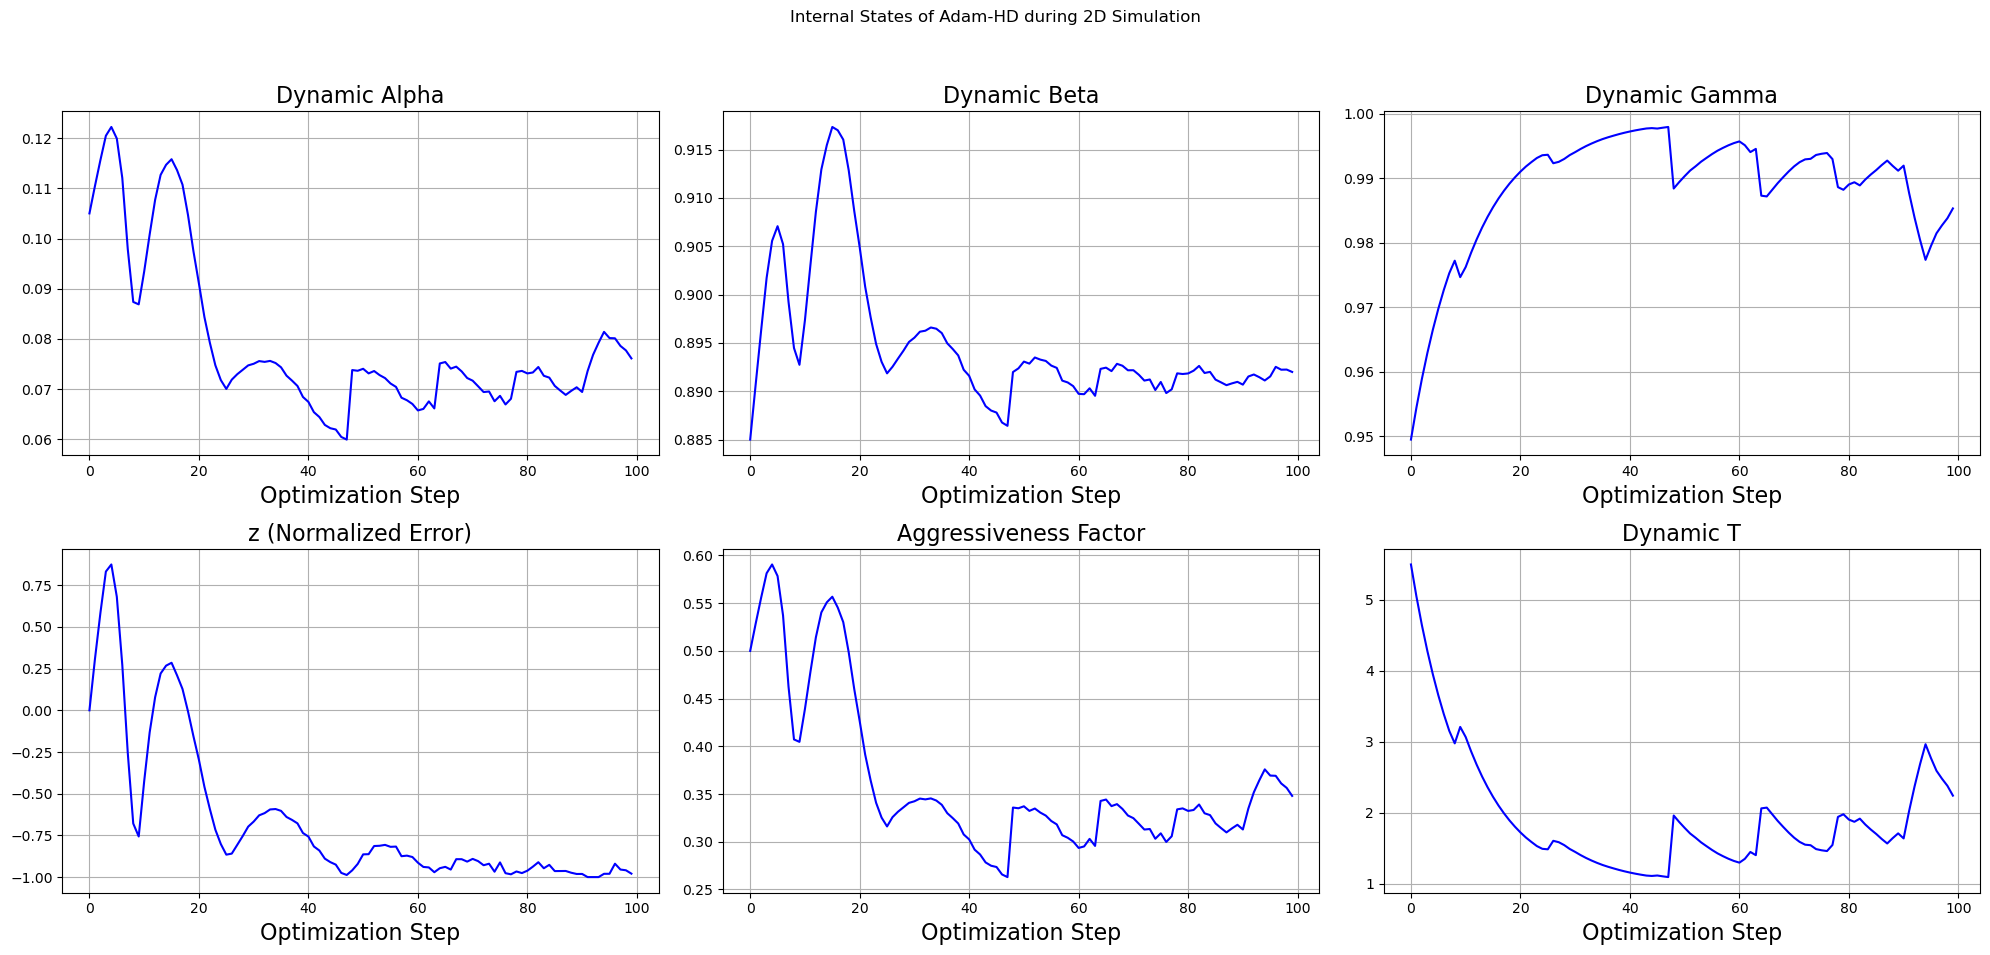


--- Treinando MLP com Adam-HD ---
Epoch 1: Loss = 0.2385, Accuracy = 96.48%
Epoch 2: Loss = 0.0940, Accuracy = 96.74%
Epoch 3: Loss = 0.0667, Accuracy = 97.20%
Epoch 4: Loss = 0.0505, Accuracy = 97.66%
Epoch 5: Loss = 0.0423, Accuracy = 98.15%
Epoch 6: Loss = 0.0348, Accuracy = 97.43%
Epoch 7: Loss = 0.0309, Accuracy = 97.98%
Epoch 8: Loss = 0.0274, Accuracy = 98.19%
Epoch 9: Loss = 0.0252, Accuracy = 97.95%
Epoch 10: Loss = 0.0243, Accuracy = 98.02%
Epoch 11: Loss = 0.0229, Accuracy = 97.94%
Epoch 12: Loss = 0.0206, Accuracy = 97.98%
Epoch 13: Loss = 0.0204, Accuracy = 97.97%
Epoch 14: Loss = 0.0200, Accuracy = 98.28%
Epoch 15: Loss = 0.0176, Accuracy = 98.20%
Epoch 16: Loss = 0.0177, Accuracy = 98.20%
Epoch 17: Loss = 0.0208, Accuracy = 97.97%
Epoch 18: Loss = 0.0191, Accuracy = 98.03%
Epoch 19: Loss = 0.0184, Accuracy = 98.02%
Epoch 20: Loss = 0.0194, Accuracy = 98.17%
Epoch 21: Loss = 0.0169, Accuracy = 98.06%
Epoch 22: Loss = 0.0175, Accuracy = 98.30%
Epoch 23: Loss = 0.0145, Acc

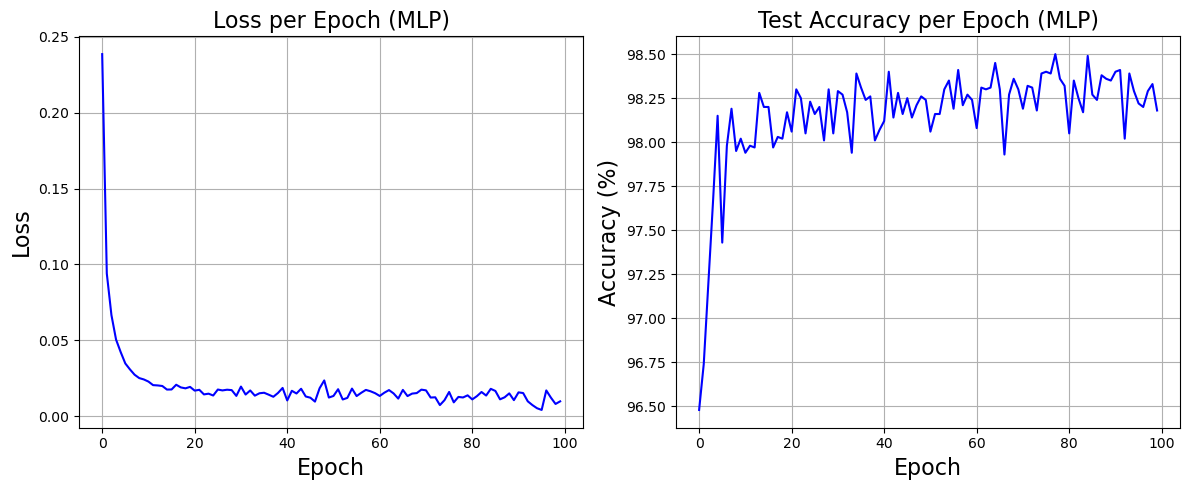


--- Plotando estados internos do otimizador para: MLP Training ---


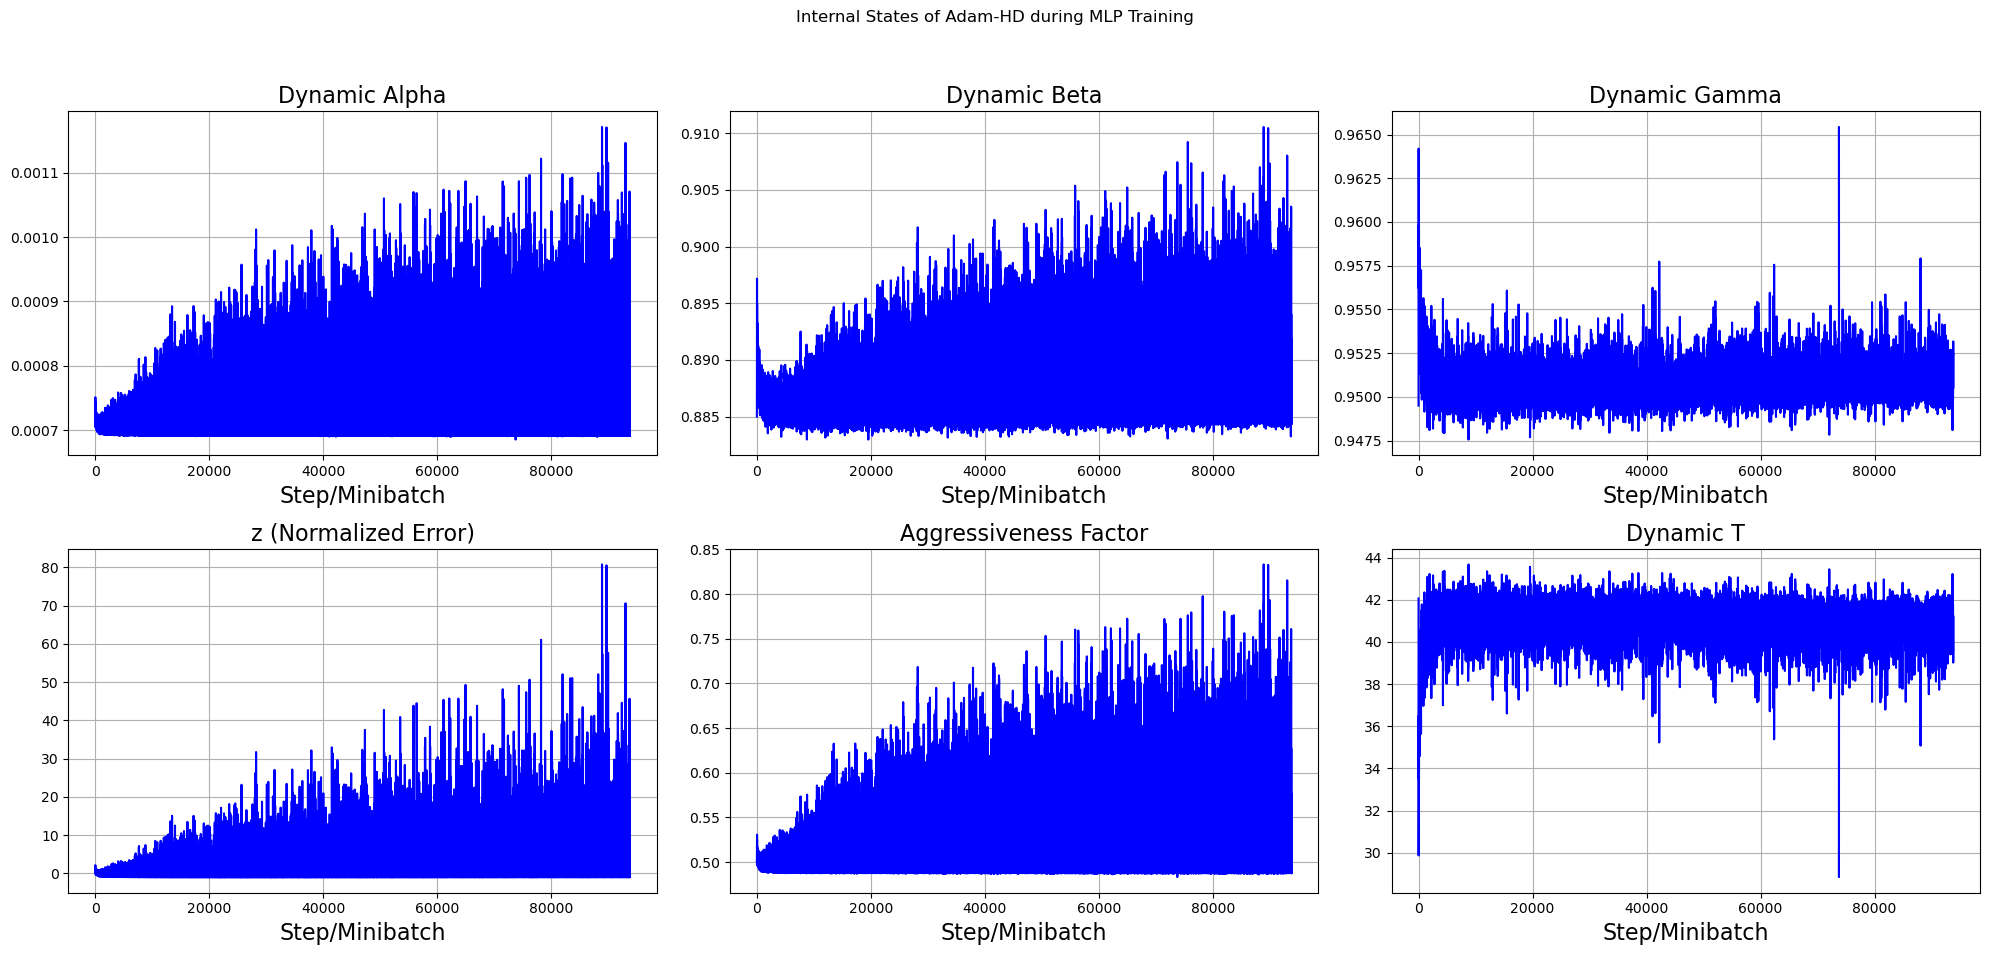

In [37]:
###############################################################################################################################################
########## VISUALIZATION & ADAM-HD V2 IMPLEMENTATION (FINAL UNIFIED VERSION) #########
###############################################################################################################################################

# --- 1. IMPORTAÇÃO DE BIBLIOTECAS ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- REPRODUCIBILIDADE ---
torch.manual_seed(0)
np.random.seed(0)

#######################################################################################################
# --- PARÂMETROS GLOBAIS E UNIFICADOS ---
#######################################################################################################
# Parâmetros que controlam AMBOS os experimentos (2D e MLP)
# Valores encontrados pelo Optuna usados como padrão
ALPHA_MIN = 0.000014 # Valor Anterior: 0.0000177
ALPHA_MAX = 0.001403 # Valor Anterior: 0.001273
T_RANGE = (1.0, 83.1290) # T_min=1 (softsign pura), T_max=valor otimizado

# Parâmetro de controle único para os passos
NUMERO_DE_PASSOS = 100

#######################################################################################################
# --- ESTRUTURA DO OTIMIZADOR E DA REDE NEURAL ---
#######################################################################################################

class MLPDeep(nn.Module):
    """Define a arquitetura da Rede Neural."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

class AdamHDOptimizer(torch.optim.Optimizer):
    """ Implementação do Adam-HD v2: T dinâmico """
    def __init__(self, params, alpha_range, T_range,
                 beta_range=(0.85, 0.99), gamma_range=(0.9, 0.999),
                 smoothing_direcao=0.9, epsilon=1e-8, beta_norm=0.99):
        defaults = dict(alpha_range=alpha_range, T_range=T_range,
                        beta_range=beta_range, gamma_range=gamma_range,
                        smoothing_direcao=smoothing_direcao, epsilon=epsilon,
                        beta_norm=beta_norm)
        super().__init__(params, defaults)
        # Inicializa as listas de histórico
        self.alpha_hist, self.beta_hist, self.gamma_hist = [], [], []
        self.T_hist, self.z_hist, self.aggressiveness_hist = [], [], []

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            alpha_min, alpha_max = group['alpha_range']
            T_min, T_max = group['T_range']
            beta_min, beta_max = group['beta_range']
            gamma_min, gamma_max = group['gamma_range']
            smoothing = group['smoothing_direcao']
            eps = group['epsilon']
            beta_norm = group['beta_norm']

            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                grad = p.grad.data
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['grad_prev'] = torch.zeros_like(p.data)
                    state['cos_smooth'] = torch.tensor(0.0, device=p.device)
                    state['avg_grad_norm'] = torch.tensor(0.0, device=p.device)

                state['step'] += 1
                m, v, grad_prev, cos_smooth, avg_grad_norm = state['m'], state['v'], state['grad_prev'], state['cos_smooth'], state['avg_grad_norm']

                grad_norm = grad.norm()
                if avg_grad_norm.item() == 0:
                    avg_grad_norm.copy_(grad_norm)
                else:
                    avg_grad_norm.mul_(beta_norm).add_(grad_norm, alpha=1 - beta_norm)

                z = (grad_norm / (avg_grad_norm + eps)) - 1.0
                if grad_prev.norm() > 0 and grad_norm > 0:
                    cos_atual = torch.dot(grad.view(-1), grad_prev.view(-1)) / (grad_norm * grad_prev.norm())
                else:
                    cos_atual = torch.tensor(0.0, device=p.device)
                cos_smooth.mul_(smoothing).add_(cos_atual, alpha=1 - smoothing)
                factor_direcao = (cos_smooth + 1) / 2.0
                T_t = T_max - (T_max - T_min) * factor_direcao
                softsign = z / (T_t + z.abs())
                factor_agressividade = 0.5 * (softsign + 1)

                alpha = alpha_min + (alpha_max - alpha_min) * factor_agressividade
                beta_target = beta_min + (beta_max - beta_min) * factor_direcao
                beta = factor_agressividade * beta_target + (1 - factor_agressividade) * beta_min
                gamma = gamma_min + (gamma_max - gamma_min) * factor_direcao

                m.mul_(beta).add_(grad, alpha=1 - beta)
                v.mul_(gamma).addcmul_(grad, grad, value=1 - gamma)
                bias_correction1 = 1 - beta ** state['step']
                bias_correction2 = 1 - gamma ** state['step']
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2

                p.data.addcdiv_(m_hat, v_hat.sqrt().add(eps), value=-alpha)
                state['grad_prev'].copy_(grad)

                if id(p) == id(group['params'][0]):
                    self.alpha_hist.append(alpha.item())
                    self.beta_hist.append(beta.item())
                    self.gamma_hist.append(gamma.item())
                    self.T_hist.append(T_t.item())
                    self.z_hist.append(z.item())
                    self.aggressiveness_hist.append(factor_agressividade.item())

#######################################################################################################
# --- SEÇÃO DE EXECUÇÃO E PLOTAGEM ---
#######################################################################################################

def plot_optimizer_history(optimizer, title_suffix, xlabel="Default X-Label", xlabel_fontsize=16):
    """Plota o histórico dos estados internos do otimizador."""
    if not optimizer.alpha_hist:
        print(f"Histórico do otimizador para '{title_suffix}' está vazio. Gráficos não gerados.")
        return

    print(f"\n--- Plotando estados internos do otimizador para: {title_suffix} ---")
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(f'Internal States of Adam-HD during {title_suffix}')

    axs[0, 0].plot(optimizer.alpha_hist, color='blue')
    axs[0, 0].set_title('Dynamic Alpha', fontsize=16)

    axs[0, 1].plot(optimizer.beta_hist, color='blue')
    axs[0, 1].set_title('Dynamic Beta', fontsize=16)

    axs[0, 2].plot(optimizer.gamma_hist, color='blue')
    axs[0, 2].set_title('Dynamic Gamma', fontsize=16)

    axs[1, 0].plot(optimizer.z_hist, color='blue')
    axs[1, 0].set_title('z (Normalized Error)', fontsize=16)

    axs[1, 1].plot(optimizer.aggressiveness_hist, color='blue')
    axs[1, 1].set_title('Aggressiveness Factor', fontsize=16)

    axs[1, 2].plot(optimizer.T_hist, color='blue')
    axs[1, 2].set_title('Dynamic T', fontsize=16)

    for ax in axs.flat:
        ax.grid(True)
        ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def run_2d_simulation():
    """Usa a classe AdamHDOptimizer para a simulação 2D."""
    print("\n--- Rodando Simulação 2D com Adam-HD ---")

    # Funções auxiliares específicas para a simulação 2D
    def loss_2d(phi0, phi1):
        height = np.exp(-0.5 * (phi1**2) * 4.0) * np.exp(-0.5 * (phi0 - 0.7)**2 / 4.0)
        return 1.0 - height

    def get_loss_gradient_2d(phi0, phi1):
        delta_phi = 1e-5
        grad = np.zeros(2)
        grad[0] = (loss_2d(phi0 + delta_phi / 2.0, phi1) - loss_2d(phi0 - delta_phi / 2.0, phi1)) / delta_phi
        grad[1] = (loss_2d(phi0, phi1 + delta_phi / 2.0) - loss_2d(phi0, phi1 - delta_phi / 2.0)) / delta_phi
        return grad

    # Preparar paisagem de perda para o plot
    phi0_values = np.arange(-1.2, 1.2, 0.01)
    phi1_values = np.arange(-1.2, 1.2, 0.01)
    phi0mesh, phi1mesh = np.meshgrid(phi0_values, phi1_values)
    loss_function = np.zeros((phi1_values.size, phi0_values.size))
    for idphi1, phi1 in enumerate(phi1_values):
        for idphi0, phi0 in enumerate(phi0_values):
            loss_function[idphi1, idphi0] = loss_2d(phi0, phi1)

    # Configurar e rodar a otimização
    params_2d = torch.nn.Parameter(torch.tensor([-0.7, -0.9]))

    # Parâmetros para esta simulação específica
    alpha_range_2d = (0.01, 0.2)
    t_range_2d = (1.0, 10.0)
    
    optimizer_2d = AdamHDOptimizer([params_2d],
                                   alpha_range=alpha_range_2d, # Range mais agressivo para o problema simples
                                   T_range=t_range_2d)

    path_history = []
    for step in range(NUMERO_DE_PASSOS):
        path_history.append(params_2d.data.clone().numpy())
        optimizer_2d.zero_grad()
        current_pos = params_2d.data.numpy()
        grad = get_loss_gradient_2d(current_pos[0], current_pos[1])
        params_2d.grad = torch.tensor(grad, dtype=params_2d.dtype)
        optimizer_2d.step()
    path_history.append(params_2d.data.clone().numpy())

    # <<<< INÍCIO DAS ALTERAÇÕES >>>>
    
    # 1. Obter os parâmetros fixos dos valores padrão da classe
    defaults = optimizer_2d.defaults
    beta_range_2d = defaults['beta_range']
    gamma_range_2d = defaults['gamma_range']
    smoothing_2d = defaults['smoothing_direcao']
    beta_norm_2d = defaults['beta_norm']

    # 2. Criar o texto completo da legenda
    legend_text = (
        f"Adam-HD v2\n"
        f"$\\alpha \\in [{alpha_range_2d[0]}, {alpha_range_2d[1]}]$\n"
        f"$T \\in [{t_range_2d[0]}, {t_range_2d[1]}]$\n"
        f"$\\beta \\in [{beta_range_2d[0]}, {beta_range_2d[1]}]$\n"
        f"$\\gamma \\in [{gamma_range_2d[0]}, {gamma_range_2d[1]}]$\n"
        f"$\\beta_{{smooth}} = {smoothing_2d}$\n"
        f"$\\beta_{{norm}} = {beta_norm_2d}$"
    )
    
    # Plotar a trajetória
    print("\nPlotando a trajetória na paisagem de perda 2D:")
    my_colormap = plt.get_cmap('pink')
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.contourf(phi0mesh, phi1mesh, loss_function, 256, cmap=my_colormap)
    ax.contour(phi0mesh, phi1mesh, loss_function, 20, colors=['#80808080'])
    ax.plot(np.array(path_history).T[0, :], np.array(path_history).T[1, :], '-', color='#a0d9d3ff')
    ax.plot(np.array(path_history).T[0, :], np.array(path_history).T[1, :], '.', color='#a0d9d3ff', markersize=10)
    ax.set_xlabel(r"$\phi_0$", fontsize=16)
    ax.set_ylabel(r"$\phi_1$", fontsize=16)

    # 3. Adicionar o texto com fundo transparente
    #    alpha=0.0 torna o fundo da caixa totalmente transparente.
    #    facecolor='none' também funciona.
    ax.text(0.95, 0.05, legend_text,
            transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.0, edgecolor='gray'))
            
    
    plt.show()

    # Plotar os estados internos
    plot_optimizer_history(optimizer_2d, "2D Simulation", xlabel="Optimization Step", xlabel_fontsize=16)
    

def run_mlp_training():
    """Executa o treinamento da MLP no MNIST com Adam-HD."""
    print("\n--- Treinando MLP com Adam-HD ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = DataLoader(datasets.MNIST(root='./data', train=True, download=True, transform=transform), batch_size=64, shuffle=True)
    test_loader = DataLoader(datasets.MNIST(root='./data', train=False, transform=transform), batch_size=1000, shuffle=False)

    model = MLPDeep().to(device)
    optimizer = AdamHDOptimizer(model.parameters(),
                                alpha_range=(ALPHA_MIN, ALPHA_MAX),
                                T_range=T_RANGE)

    criterion = nn.CrossEntropyLoss()
    train_losses, test_accuracies = [], []

    for epoch in range(1, NUMERO_DE_PASSOS + 1):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

    print(f"\nFinal Accuracy with Adam-HD v2: {test_accuracies[-1]:.2f}%")

    # Gráficos de Desempenho
    #plt.figure(figsize=(12, 5))
    #plt.subplot(1, 2, 1)
    #plt.plot(train_losses, marker='o')
    #plt.title('Loss per Epoch (MLP)')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.grid(True)
    #plt.subplot(1, 2, 2)
    #plt.plot(test_accuracies, marker='s', color='orange')
    #plt.title('Test Accuracy per Epoch (MLP)')
    #plt.xlabel('Epoch')
    #plt.ylabel('Accuracy (%)')
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()


    # Gráficos de Desempenho
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color='blue')
    plt.title('Loss per Epoch (MLP)', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, color='blue')
    plt.title('Test Accuracy per Epoch (MLP)', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy (%)', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    # Plotar os estados internos
    plot_optimizer_history(optimizer, "MLP Training", xlabel="Step/Minibatch")


# --- PONTO DE ENTRADA PRINCIPAL ---
if __name__ == '__main__':
    # Roda as visualizações iniciais, se desejado
    #visualize_activation_functions()
    #visualize_flattening_factor()

    # Roda a simulação 2D com a nova lógica v2
    run_2d_simulation()

    # Roda o treinamento principal da MLP
    run_mlp_training()

# **Comparação Adam x Adam-HD**

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- REPRODUCIBILIDADE ---
# Garante que os resultados sejam os mesmos a cada execução
torch.manual_seed(0)
np.random.seed(0)

#######################################################################################################
# --- PARÂMETROS GLOBAIS ---
#######################################################################################################
# Parâmetros para o treinamento da MLP
NUM_EPOCHS = 100
BATCH_SIZE = 64
ADAM_LR = 0.001 # Taxa de aprendizado padrão para o Adam baseline

# Valores encontrados pelo Optuna usados como padrão
ALPHA_MIN = 0.000014
ALPHA_MAX = 0.001403
T_RANGE = (1.0, 83.1290) # T_min=1 (softsign pura), T_max=valor otimizado

#######################################################################################################
# --- ESTRUTURA DO OTIMIZADOR E DA REDE NEURAL ---
#######################################################################################################

class MLPDeep(nn.Module):
    """Define a arquitetura da Rede Neural (idêntica para ambos os testes)."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

class AdamHDV2Optimizer(torch.optim.Optimizer):
    """ Implementação do Adam-HD v2: T dinâmico"""
    def __init__(self, params, alpha_range, T_range,
                 beta_range=(0.85, 0.99), gamma_range=(0.9, 0.999),
                 smoothing_direcao=0.9, epsilon=1e-8, beta_norm=0.99):
        defaults = dict(alpha_range=alpha_range, T_range=T_range,
                        beta_range=beta_range, gamma_range=gamma_range,
                        smoothing_direcao=smoothing_direcao, epsilon=epsilon,
                        beta_norm=beta_norm)
        super().__init__(params, defaults)
        # Inicializa as listas de histórico para análise posterior
        self.alpha_hist, self.beta_hist, self.gamma_hist = [], [], []
        self.T_hist, self.z_hist, self.aggressiveness_hist = [], [], []

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            alpha_min, alpha_max = group['alpha_range']
            T_min, T_max = group['T_range']
            beta_min, beta_max = group['beta_range']
            gamma_min, gamma_max = group['gamma_range']
            smoothing = group['smoothing_direcao']
            eps = group['epsilon']
            beta_norm = group['beta_norm']

            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                grad = p.grad.data
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['grad_prev'] = torch.zeros_like(p.data)
                    state['cos_smooth'] = torch.tensor(0.0, device=p.device)
                    state['avg_grad_norm'] = torch.tensor(0.0, device=p.device)

                state['step'] += 1
                m, v, grad_prev, cos_smooth, avg_grad_norm = state['m'], state['v'], state['grad_prev'], state['cos_smooth'], state['avg_grad_norm']

                grad_norm = grad.norm()
                if avg_grad_norm.item() == 0:
                    avg_grad_norm.copy_(grad_norm)
                else:
                    avg_grad_norm.mul_(beta_norm).add_(grad_norm, alpha=1 - beta_norm)
                
                z = (grad_norm / (avg_grad_norm + eps)) - 1.0
                if grad_prev.norm() > 0 and grad_norm > 0:
                    cos_atual = torch.dot(grad.view(-1), grad_prev.view(-1)) / (grad_norm * grad_prev.norm())
                else:
                    cos_atual = torch.tensor(0.0, device=p.device)
                cos_smooth.mul_(smoothing).add_(cos_atual, alpha=1 - smoothing)
                factor_direcao = (cos_smooth + 1) / 2.0
                T_t = T_max - (T_max - T_min) * factor_direcao
                softsign = z / (T_t + z.abs())
                factor_agressividade = 0.5 * (softsign + 1)
                
                alpha = alpha_min + (alpha_max - alpha_min) * factor_agressividade
                beta_target = beta_min + (beta_max - beta_min) * factor_direcao
                beta = factor_agressividade * beta_target + (1 - factor_agressividade) * beta_min
                gamma = gamma_min + (gamma_max - gamma_min) * factor_direcao

                m.mul_(beta).add_(grad, alpha=1 - beta)
                v.mul_(gamma).addcmul_(grad, grad, value=1 - gamma)
                bias_correction1 = 1 - beta ** state['step']
                bias_correction2 = 1 - gamma ** state['step']
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2
                
                p.data.addcdiv_(m_hat, v_hat.sqrt().add(eps), value=-alpha)
                state['grad_prev'].copy_(grad)

                if id(p) == id(group['params'][0]):
                    self.alpha_hist.append(alpha.item())
                    self.beta_hist.append(beta.item())
                    self.gamma_hist.append(gamma.item())
                    self.T_hist.append(T_t.item())
                    self.z_hist.append(z.item())
                    self.aggressiveness_hist.append(factor_agressividade.item())

#######################################################################################################
# --- SEÇÃO DE TREINAMENTO E COMPARAÇÃO ---
#######################################################################################################

# Dataset e DataLoader (comum para ambos os testes)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=1000, shuffle=False)

# Função de treino e avaliação genérica
def train_and_eval(model, optimizer, num_epochs=NUM_EPOCHS):
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_losses, test_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Avaliação a cada época
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        acc = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(acc)
        print(f"Epoch {epoch + 1}/{num_epochs}: Loss = {avg_loss:.4f} | Accuracy = {acc:.2f}%")
        
    return train_losses, test_accuracies

# --- Execução do Treinamento para o Adam Padrão ---
print("\n--- Training Adam (Baseline) ---")
model_adam = MLPDeep()
optimizer_adam = optim.Adam(model_adam.parameters(), lr=ADAM_LR)
adam_loss, adam_acc = train_and_eval(model_adam, optimizer_adam)
print(f"Acurácia Final (Adam): {adam_acc[-1]:.2f}%")

# <<< Resetar a semente para garantir reprodutibilidade >>>
torch.manual_seed(0)
np.random.seed(0)

# --- Execução do Treinamento para o Adam-HD v2 ---
print("\n--- Training Adam-HD ---")
model_adamhd_v2 = MLPDeep()
optimizer_adamhd_v2 = AdamHDV2Optimizer(model_adamhd_v2.parameters(),
                                      alpha_range=(ALPHA_MIN, ALPHA_MAX),
                                      T_range=T_RANGE)
adam_hd_v2_loss, adam_hd_v2_acc = train_and_eval(model_adamhd_v2, optimizer_adamhd_v2)
print(f"Final Accuracy (Adam-HD): {adam_hd_v2_acc[-1]:.2f}%")

# --- Gráficos Comparativos ---
print("\n--- Generating Comparison Charts ---")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(adam_loss, label='Adam', color='orange', linestyle='--')
plt.plot(adam_hd_v2_loss, label='Adam-HD', color='blue')
plt.title('Loss per Epoch Comparison', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(adam_acc, label='Adam', color='orange', linestyle='--')
plt.plot(adam_hd_v2_acc, label='Adam-HD', color='blue')
plt.title('Accuracy per Epoch Comparison', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()




--- Training Adam (Baseline) ---
Epoch 1/100: Loss = 0.2261 | Accuracy = 96.48%
Epoch 2/100: Loss = 0.0963 | Accuracy = 97.27%
Epoch 3/100: Loss = 0.0693 | Accuracy = 97.43%
Epoch 4/100: Loss = 0.0517 | Accuracy = 97.54%
Epoch 5/100: Loss = 0.0428 | Accuracy = 97.81%
Epoch 6/100: Loss = 0.0370 | Accuracy = 97.45%
Epoch 7/100: Loss = 0.0300 | Accuracy = 97.41%
Epoch 8/100: Loss = 0.0293 | Accuracy = 97.60%
Epoch 9/100: Loss = 0.0261 | Accuracy = 98.04%
Epoch 10/100: Loss = 0.0204 | Accuracy = 98.18%
Epoch 11/100: Loss = 0.0237 | Accuracy = 97.91%
Epoch 12/100: Loss = 0.0168 | Accuracy = 98.21%
Epoch 13/100: Loss = 0.0197 | Accuracy = 98.15%
Epoch 14/100: Loss = 0.0160 | Accuracy = 98.26%
Epoch 15/100: Loss = 0.0138 | Accuracy = 98.22%
Epoch 16/100: Loss = 0.0150 | Accuracy = 98.22%
Epoch 17/100: Loss = 0.0134 | Accuracy = 98.04%
Epoch 18/100: Loss = 0.0165 | Accuracy = 98.27%
Epoch 19/100: Loss = 0.0131 | Accuracy = 98.22%


KeyboardInterrupt: 

# **Nova Comparação entre Adam-HD e Adam - Equiparação de Software**


--- Training Adam (Baseline) ---
Epoch 1/100: Loss = 0.2261 | Accuracy = 96.48%
Epoch 2/100: Loss = 0.0963 | Accuracy = 97.27%
Epoch 3/100: Loss = 0.0693 | Accuracy = 97.43%
Epoch 4/100: Loss = 0.0517 | Accuracy = 97.54%
Epoch 5/100: Loss = 0.0428 | Accuracy = 97.81%
Epoch 6/100: Loss = 0.0370 | Accuracy = 97.45%
Epoch 7/100: Loss = 0.0300 | Accuracy = 97.41%
Epoch 8/100: Loss = 0.0293 | Accuracy = 97.60%
Epoch 9/100: Loss = 0.0261 | Accuracy = 98.04%
Epoch 10/100: Loss = 0.0204 | Accuracy = 98.18%
Epoch 11/100: Loss = 0.0237 | Accuracy = 97.91%
Epoch 12/100: Loss = 0.0168 | Accuracy = 98.21%
Epoch 13/100: Loss = 0.0197 | Accuracy = 98.15%
Epoch 14/100: Loss = 0.0160 | Accuracy = 98.26%
Epoch 15/100: Loss = 0.0138 | Accuracy = 98.22%
Epoch 16/100: Loss = 0.0150 | Accuracy = 98.22%
Epoch 17/100: Loss = 0.0134 | Accuracy = 98.04%
Epoch 18/100: Loss = 0.0165 | Accuracy = 98.27%
Epoch 19/100: Loss = 0.0131 | Accuracy = 98.22%
Epoch 20/100: Loss = 0.0104 | Accuracy = 98.04%
Epoch 21/100: L

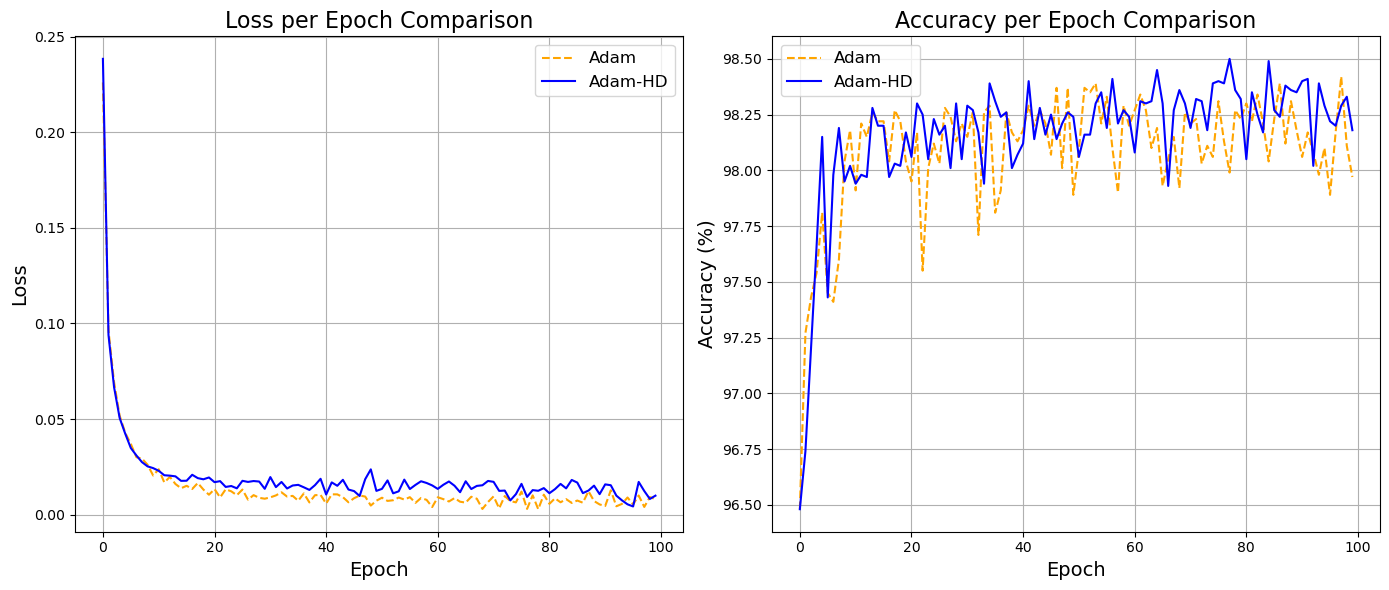

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PARÂMETROS GLOBAIS E UNIFICADOS ---
# Semente para garantir a reprodutibilidade
MANUAL_SEED = 0

# Parâmetros de treinamento
NUM_EPOCHS = 100
BATCH_SIZE = 64
ADAM_LR = 0.001

# Parâmetros do Adam-HD (otimizados)
ALPHA_MIN = 0.000014
ALPHA_MAX = 0.001403
T_RANGE = (1.0, 83.1290)

# --- 2. ESTRUTURA DA REDE E DO OTIMIZADOR ---
# (As classes MLPDeep e AdamHDOptimizer/AdamHDV2Optimizer permanecem as mesmas)

class MLPDeep(nn.Module):
    """Define a arquitetura da Rede Neural (idêntica para ambos os testes)."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

class AdamHDOptimizer(torch.optim.Optimizer):
    """ Implementação do Adam-HD v2: T dinâmico"""
    def __init__(self, params, alpha_range, T_range,
                 beta_range=(0.85, 0.99), gamma_range=(0.9, 0.999),
                 smoothing_direcao=0.9, epsilon=1e-8, beta_norm=0.99):
        defaults = dict(alpha_range=alpha_range, T_range=T_range,
                        beta_range=beta_range, gamma_range=gamma_range,
                        smoothing_direcao=smoothing_direcao, epsilon=epsilon,
                        beta_norm=beta_norm)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        # ... (a lógica interna do step() é a mesma dos códigos anteriores) ...
        for group in self.param_groups:
            alpha_min, alpha_max = group['alpha_range']
            T_min, T_max = group['T_range']
            beta_min, beta_max = group['beta_range']
            gamma_min, gamma_max = group['gamma_range']
            smoothing = group['smoothing_direcao']
            eps = group['epsilon']
            beta_norm = group['beta_norm']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                grad = p.grad.data
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['grad_prev'] = torch.zeros_like(p.data)
                    state['cos_smooth'] = torch.tensor(0.0, device=p.device)
                    state['avg_grad_norm'] = torch.tensor(0.0, device=p.device)
                state['step'] += 1
                m, v, grad_prev, cos_smooth, avg_grad_norm = state['m'], state['v'], state['grad_prev'], state['cos_smooth'], state['avg_grad_norm']
                grad_norm = grad.norm()
                if avg_grad_norm.item() == 0:
                    avg_grad_norm.copy_(grad_norm)
                else:
                    avg_grad_norm.mul_(beta_norm).add_(grad_norm, alpha=1 - beta_norm)
                z = (grad_norm / (avg_grad_norm + eps)) - 1.0
                if grad_prev.norm() > 0 and grad_norm > 0:
                    cos_atual = torch.dot(grad.view(-1), grad_prev.view(-1)) / (grad_norm * grad_prev.norm())
                else:
                    cos_atual = torch.tensor(0.0, device=p.device)
                cos_smooth.mul_(smoothing).add_(cos_atual, alpha=1 - smoothing)
                factor_direcao = (cos_smooth + 1) / 2.0
                T_t = T_max - (T_max - T_min) * factor_direcao
                softsign = z / (T_t + z.abs())
                factor_agressividade = 0.5 * (softsign + 1)
                alpha = alpha_min + (alpha_max - alpha_min) * factor_agressividade
                beta_target = beta_min + (beta_max - beta_min) * factor_direcao
                beta = factor_agressividade * beta_target + (1 - factor_agressividade) * beta_min
                gamma = gamma_min + (gamma_max - gamma_min) * factor_direcao
                m.mul_(beta).add_(grad, alpha=1 - beta)
                v.mul_(gamma).addcmul_(grad, grad, value=1 - gamma)
                bias_correction1 = 1 - beta ** state['step']
                bias_correction2 = 1 - gamma ** state['step']
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2
                p.data.addcdiv_(m_hat, v_hat.sqrt().add(eps), value=-alpha)
                state['grad_prev'].copy_(grad)


# --- 3. DATA LOADERS E FUNÇÃO DE TREINO GENÉRICA ---

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=1000, shuffle=False)

def train_and_eval(model, optimizer, device, num_epochs=NUM_EPOCHS):
    """Função de treino e avaliação genérica e unificada."""
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    train_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        acc = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(acc)
        print(f"Epoch {epoch}/{num_epochs}: Loss = {avg_loss:.4f} | Accuracy = {acc:.2f}%")

    return train_losses, test_accuracies

# --- 4. FUNÇÕES PARA CADA EXPERIMENTO ---

def run_adam_experiment(device):
    """Executa o treinamento para o Adam padrão."""
    print("\n--- Training Adam (Baseline) ---")
    torch.manual_seed(MANUAL_SEED)
    np.random.seed(MANUAL_SEED)
    
    model_adam = MLPDeep()
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=ADAM_LR)
    loss, acc = train_and_eval(model_adam, optimizer_adam, device)
    print(f"Acurácia Final (Adam): {acc[-1]:.2f}%")
    return loss, acc

def run_adam_hd_experiment(device):
    """Executa o treinamento para o Adam-HD."""
    print("\n--- Training Adam-HD ---")
    torch.manual_seed(MANUAL_SEED)
    np.random.seed(MANUAL_SEED)

    model_adamhd = MLPDeep()
    optimizer_adamhd = AdamHDOptimizer(model_adamhd.parameters(),
                                       alpha_range=(ALPHA_MIN, ALPHA_MAX),
                                       T_range=T_RANGE)
    loss, acc = train_and_eval(model_adamhd, optimizer_adamhd, device)
    print(f"Final Accuracy (Adam-HD): {acc[-1]:.2f}%")
    return loss, acc

# --- 5. FUNÇÃO DE PLOTAGEM COMPARATIVA ---

def plot_comparison(results):
    """Plota os gráficos comparativos de Loss e Accuracy."""
    print("\n--- Generating Comparison Charts ---")
    plt.figure(figsize=(14, 6))

    # Gráfico de Loss
    plt.subplot(1, 2, 1)
    for name, (loss, _) in results.items():
        linestyle = '--' if name == 'Adam' else '-'
        color = 'orange' if name == 'Adam' else 'blue'
        plt.plot(loss, label=name, color=color, linestyle=linestyle)
    plt.title('Loss per Epoch Comparison', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Gráfico de Accuracy
    plt.subplot(1, 2, 2)
    for name, (_, acc) in results.items():
        linestyle = '--' if name == 'Adam' else '-'
        color = 'orange' if name == 'Adam' else 'blue'
        plt.plot(acc, label=name, color=color, linestyle=linestyle)
    plt.title('Accuracy per Epoch Comparison', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- 6. PONTO DE ENTRADA PRINCIPAL ---

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Executa os dois experimentos
    adam_loss, adam_acc = run_adam_experiment(device)
    adam_hd_loss, adam_hd_acc = run_adam_hd_experiment(device)
    
    # Armazena os resultados para plotagem
    results_to_plot = {
        'Adam': (adam_loss, adam_acc),
        'Adam-HD': (adam_hd_loss, adam_hd_acc)
    }
    
    # Plota a comparação
    plot_comparison(results_to_plot)

# **Nova Comparação entre Adam-HD e Adam - Equiparação de Software Versão 2**


--- Training Adam (Baseline) ---
Epoch 1/100: Loss = 0.2261 | Accuracy = 96.48%
Epoch 2/100: Loss = 0.0963 | Accuracy = 97.27%
Epoch 3/100: Loss = 0.0693 | Accuracy = 97.43%
Epoch 4/100: Loss = 0.0517 | Accuracy = 97.54%
Epoch 5/100: Loss = 0.0428 | Accuracy = 97.81%
Epoch 6/100: Loss = 0.0370 | Accuracy = 97.45%
Epoch 7/100: Loss = 0.0300 | Accuracy = 97.41%
Epoch 8/100: Loss = 0.0293 | Accuracy = 97.60%
Epoch 9/100: Loss = 0.0261 | Accuracy = 98.04%
Epoch 10/100: Loss = 0.0204 | Accuracy = 98.18%
Epoch 11/100: Loss = 0.0237 | Accuracy = 97.91%
Epoch 12/100: Loss = 0.0168 | Accuracy = 98.21%
Epoch 13/100: Loss = 0.0197 | Accuracy = 98.15%
Epoch 14/100: Loss = 0.0160 | Accuracy = 98.26%
Epoch 15/100: Loss = 0.0138 | Accuracy = 98.22%
Epoch 16/100: Loss = 0.0150 | Accuracy = 98.22%
Epoch 17/100: Loss = 0.0134 | Accuracy = 98.04%
Epoch 18/100: Loss = 0.0165 | Accuracy = 98.27%
Epoch 19/100: Loss = 0.0131 | Accuracy = 98.22%
Epoch 20/100: Loss = 0.0104 | Accuracy = 98.04%
Epoch 21/100: L

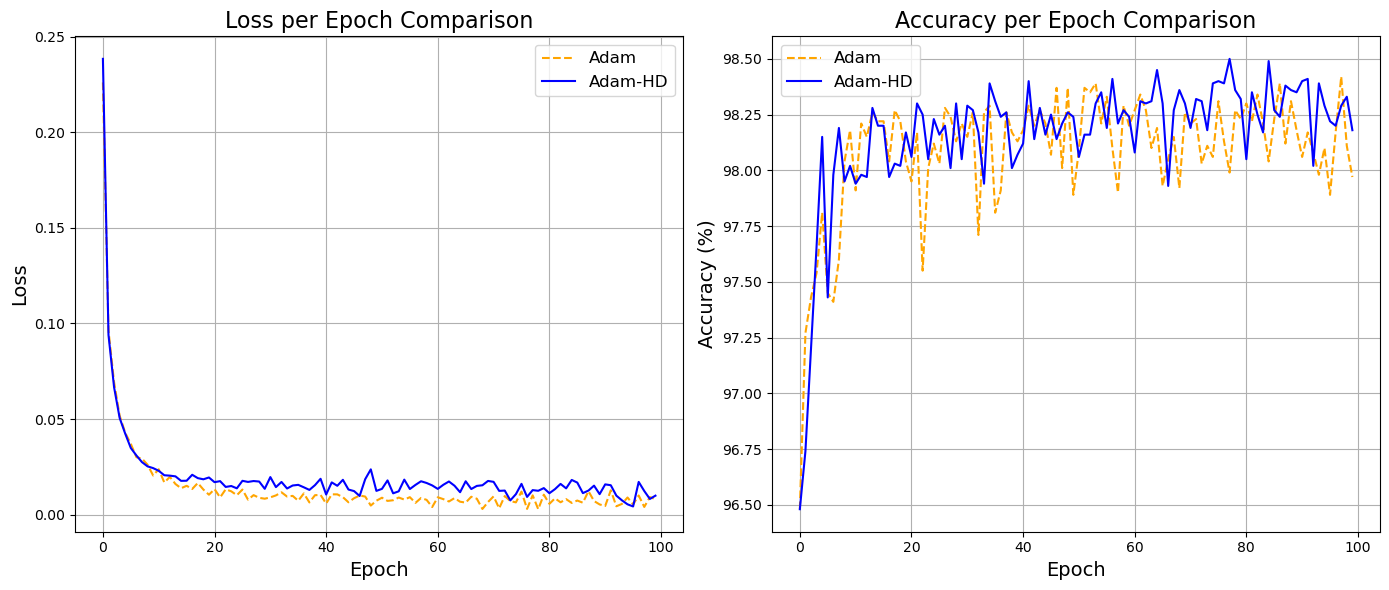

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. PARÂMETROS GLOBAIS E UNIFICADOS ---
# Semente para garantir a reprodutibilidade
MANUAL_SEED = 0

# Parâmetros de treinamento
NUM_EPOCHS = 100
BATCH_SIZE = 64
ADAM_LR = 0.001

# Parâmetros do Adam-HD (otimizados)
ALPHA_MIN = 0.000014
ALPHA_MAX = 0.001403
T_RANGE = (1.0, 83.1290)

# --- 2. ESTRUTURA DA REDE E DO OTIMIZADOR ---
# (As classes MLPDeep e AdamHDOptimizer/AdamHDV2Optimizer permanecem as mesmas)

class MLPDeep(nn.Module):
    """Define a arquitetura da Rede Neural (idêntica para ambos os testes)."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

class AdamHDOptimizer(torch.optim.Optimizer):
    """ Implementação do Adam-HD v2: T dinâmâmico"""
    def __init__(self, params, alpha_range, T_range,
                 beta_range=(0.85, 0.99), gamma_range=(0.9, 0.999),
                 smoothing_direcao=0.9, epsilon=1e-8, beta_norm=0.99):
        defaults = dict(alpha_range=alpha_range, T_range=T_range,
                        beta_range=beta_range, gamma_range=gamma_range,
                        smoothing_direcao=smoothing_direcao, epsilon=epsilon,
                        beta_norm=beta_norm)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        # ... (a lógica interna do step() é a mesma dos códigos anteriores) ...
        for group in self.param_groups:
            alpha_min, alpha_max = group['alpha_range']
            T_min, T_max = group['T_range']
            beta_min, beta_max = group['beta_range']
            gamma_min, gamma_max = group['gamma_range']
            smoothing = group['smoothing_direcao']
            eps = group['epsilon']
            beta_norm = group['beta_norm']
            for p in group['params']:
                if p.grad is None: continue
                state = self.state[p]
                grad = p.grad.data
                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p.data)
                    state['v'] = torch.zeros_like(p.data)
                    state['grad_prev'] = torch.zeros_like(p.data)
                    state['cos_smooth'] = torch.tensor(0.0, device=p.device)
                    state['avg_grad_norm'] = torch.tensor(0.0, device=p.device)
                state['step'] += 1
                m, v, grad_prev, cos_smooth, avg_grad_norm = state['m'], state['v'], state['grad_prev'], state['cos_smooth'], state['avg_grad_norm']
                grad_norm = grad.norm()
                if avg_grad_norm.item() == 0:
                    avg_grad_norm.copy_(grad_norm)
                else:
                    avg_grad_norm.mul_(beta_norm).add_(grad_norm, alpha=1 - beta_norm)
                z = (grad_norm / (avg_grad_norm + eps)) - 1.0
                if grad_prev.norm() > 0 and grad_norm > 0:
                    cos_atual = torch.dot(grad.view(-1), grad_prev.view(-1)) / (grad_norm * grad_prev.norm())
                else:
                    cos_atual = torch.tensor(0.0, device=p.device)
                cos_smooth.mul_(smoothing).add_(cos_atual, alpha=1 - smoothing)
                factor_direcao = (cos_smooth + 1) / 2.0
                T_t = T_max - (T_max - T_min) * factor_direcao
                softsign = z / (T_t + z.abs())
                factor_agressividade = 0.5 * (softsign + 1)
                alpha = alpha_min + (alpha_max - alpha_min) * factor_agressividade
                beta_target = beta_min + (beta_max - beta_min) * factor_direcao
                beta = factor_agressividade * beta_target + (1 - factor_agressividade) * beta_min
                gamma = gamma_min + (gamma_max - gamma_min) * factor_direcao
                m.mul_(beta).add_(grad, alpha=1 - beta)
                v.mul_(gamma).addcmul_(grad, grad, value=1 - gamma)
                bias_correction1 = 1 - beta ** state['step']
                bias_correction2 = 1 - gamma ** state['step']
                m_hat = m / bias_correction1
                v_hat = v / bias_correction2
                p.data.addcdiv_(m_hat, v_hat.sqrt().add(eps), value=-alpha)
                state['grad_prev'].copy_(grad)


# --- 3. DATA LOADERS E FUNÇÃO DE TREINO GENÉRICA ---

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transform), batch_size=1000, shuffle=False)

def train_and_eval(model, optimizer, device, num_epochs=NUM_EPOCHS):
    """Função de treino e avaliação genérica e unificada."""
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    train_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        acc = 100. * correct / len(test_loader.dataset)
        test_accuracies.append(acc)
        print(f"Epoch {epoch}/{num_epochs}: Loss = {avg_loss:.4f} | Accuracy = {acc:.2f}%")

    return train_losses, test_accuracies

# --- 4. FUNÇÕES PARA CADA EXPERIMENTO ---

def run_adam_experiment(device):
    """Executa o treinamento para o Adam padrão."""
    print("\n--- Training Adam (Baseline) ---")
    torch.manual_seed(MANUAL_SEED)
    np.random.seed(MANUAL_SEED)
    
    model_adam = MLPDeep()
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=ADAM_LR)
    loss, acc = train_and_eval(model_adam, optimizer_adam, device)
    print(f"Acurácia Final (Adam): {acc[-1]:.2f}%")
    return loss, acc

def run_adam_hd_experiment(device):
    """Executa o treinamento para o Adam-HD."""
    print("\n--- Training Adam-HD ---")
    torch.manual_seed(MANUAL_SEED)
    np.random.seed(MANUAL_SEED)

    model_adamhd = MLPDeep()
    optimizer_adamhd = AdamHDOptimizer(model_adamhd.parameters(),
                                       alpha_range=(ALPHA_MIN, ALPHA_MAX),
                                       T_range=T_RANGE)
    loss, acc = train_and_eval(model_adamhd, optimizer_adamhd, device)
    print(f"Final Accuracy (Adam-HD): {acc[-1]:.2f}%")
    return loss, acc

# --- 5. FUNÇÃO DE PLOTAGEM COMPARATIVA ---

def plot_comparison(results):
    """Plota os gráficos comparativos de Loss e Accuracy."""
    print("\n--- Generating Comparison Charts ---")
    plt.figure(figsize=(14, 6))

    # Gráfico de Loss
    plt.subplot(1, 2, 1)
    for name, (loss, _) in results.items():
        linestyle = '--' if name == 'Adam' else '-'
        color = 'orange' if name == 'Adam' else 'blue'
        plt.plot(loss, label=name, color=color, linestyle=linestyle)
    plt.title('Loss per Epoch Comparison', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Gráfico de Accuracy
    plt.subplot(1, 2, 2)
    for name, (_, acc) in results.items():
        linestyle = '--' if name == 'Adam' else '-'
        color = 'orange' if name == 'Adam' else 'blue'
        plt.plot(acc, label=name, color=color, linestyle=linestyle)
    plt.title('Accuracy per Epoch Comparison', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- 6. PONTO DE ENTRADA PRINCIPAL ---

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Executa os dois experimentos
    adam_loss, adam_acc = run_adam_experiment(device)
    adam_hd_loss, adam_hd_acc = run_adam_hd_experiment(device)

    # Calcula e imprime as médias (esta parte está correta)
    avg_loss_adam_from_epoch_20 = np.mean(adam_loss[19:])
    avg_acc_adam_from_epoch_20 = np.mean(adam_acc[19:])
    avg_loss_adam_hd_from_epoch_20 = np.mean(adam_hd_loss[19:])
    avg_acc_adam_hd_from_epoch_20 = np.mean(adam_hd_acc[19:])
    
    print("\n--- Médias Adam-HD e Adam ---")
        
    print(f"Média da Loss para Adam (a partir da época 20): {avg_loss_adam_from_epoch_20:.4f}")
    print(f"Média da Loss para Adam-HD (a partir da época 20): {avg_loss_adam_hd_from_epoch_20:.4f}")
    
    print(f"Média da Acc para Adam (a partir da época 20): {avg_acc_adam_from_epoch_20:.2f}%")
    print(f"Média da Acc para Adam-HD (a partir da época 20): {avg_acc_adam_hd_from_epoch_20:.2f}%")
    
    # <<< CORREÇÃO AQUI >>>
    # Armazena os resultados PARA PLOTAGEM (deve usar as listas completas)
    results_to_plot = {
        'Adam': (adam_loss, adam_acc), # Usar as listas originais
        'Adam-HD': (adam_hd_loss, adam_hd_acc) # Usar as listas originais
    }
    
    # Plota a comparação
    plot_comparison(results_to_plot)

In [54]:
# <<< NOVO CÓDIGO PARA O CÁLCULO ESPECÍFICO >>>
# Calcula a média da loss do Adam a partir da época 20 (índice 19)
avg_loss_adam_from_epoch_20 = np.mean(adam_loss[19:])
avg_acc_adam_from_epoch_20 = np.mean(adam_acc[19:])
avg_loss_adam_hd_from_epoch_20 = np.mean(adam_hd_loss[19:])
avg_acc_adam_hd_from_epoch_20 = np.mean(adam_hd_acc[19:])

print("\n--- Médias Adam-HD e Adam ---")
    
print(f"Média da Loss para Adam (a partir da época 20): {avg_loss_adam_from_epoch_20:.4f}")
print(f"Média da Loss para Adam-HD (a partir da época 20): {avg_loss_adam_hd_from_epoch_20:.4f}")

print(f"Média da Acc para Adam (a partir da época 20): {avg_acc_adam_from_epoch_20:.2f}%")
print(f"Média da Acc para Adam-HD (a partir da época 20): {avg_acc_adam_hd_from_epoch_20:.2f}%")
# <<< FIM DO NOVO CÓDIGO >>>


--- Análise Específica ---

--- Análise Específica ---
Média da Loss para Adam (a partir da época 20): 0.0082
Média da Loss para Adam-HD (a partir da época 20): 0.0143
Média da Acc para Adam (a partir da época 20): 98.15%
Média da Acc para Adam-HD (a partir da época 20): 98.25%
